#     Mr. Robot's Object Detector on Toy Reindeer, Evaluation Notebook 
## by:  Steven Smiley

* [1: Purpose](#Code_Objective_1)
* [2: Import Libraries](#Code_Objective_2)
* [3: Import and View Data](#Code_Objective_3)
* [4: Import New Tflite Model](#Code_Objective_4)
* [5: Evaluate Test Images](#Code_Objective_5)
* [6: Create A GIF](#Code_Objective_6)
* [7: References](#Code_Objective_7)

# 1. Purpose<a class="anchor" id="Code_Objective_1"></a>
The purpose of this Jupyter notebook is to evaluate the tflite model generated from the custom trained **SSD MobileNet V2 FPNLite 320x320**[2](#Ref_2).  The output tflite model will be deployed onto a Raspberry Pi 4 Model B, using the Coral Edge TPU for inference.  This is the how the DIY robot will be able to autonomously aim/shoot/retrieve the toy reindeer.   

# 2. Import Libraries <a class="anchor" id="Code_Objective_2"></a>

In [ ]:
# Support for TF2 models was added after TF 2.3.
!pip install -U --pre tensorflow=="2.2.0"

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder

%matplotlib inline

# 3. Import and View Data <a class="anchor" id="Code_Objective_3"></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [ ]:
image_dir = '/content/drive/MyDrive/Images/Toy_Images'
train_image_dir=image_dir
test_image_dir=image_dir

In [ ]:
image_list=[]
image_label_list=[]
for row in os.listdir(image_dir):
  if row.find('._')==-1:
    if row.find('.jpg')!=-1:
      dummy=row.split('.jpg')[0]+'.txt'
      for row2 in os.listdir(image_dir):
        if dummy==row2:
          image_list.append(row)
          image_label_list.append(dummy)

In [ ]:
import pandas as pd
df=pd.DataFrame((image_list,image_label_list)).T
df=df.sort_values(by=[0,1]).reset_index().drop('index',axis=1)
df

0                                        1
0         148_2021-05-07_21c40c32p150436.jpg       148_2021-05-07_21c40c32p150436.txt
1         157_2021-05-07_21c40c39p511851.jpg       157_2021-05-07_21c40c39p511851.txt
2         168_2021-05-07_21c40c48p928617.jpg       168_2021-05-07_21c40c48p928617.txt
3         189_2021-05-07_21c41c06p698927.jpg       189_2021-05-07_21c41c06p698927.txt
4         196_2021-05-07_21c41c12p521275.jpg       196_2021-05-07_21c41c12p521275.txt
..                                       ...                                      ...
250  reindeer_2021-05-05_19c18c16p242493.jpg  reindeer_2021-05-05_19c18c16p242493.txt
251  reindeer_2021-05-05_19c18c23p420774.jpg  reindeer_2021-05-05_19c18c23p420774.txt
252  reindeer_2021-05-05_19c18c25p937474.jpg  reindeer_2021-05-05_19c18c25p937474.txt
253  reindeer_2021-05-05_19c18c37p334318.jpg  reindeer_2021-05-05_19c18c37p334318.txt
254  reindeer_2021-05-05_19c18c48p435443.jpg  reindeer_2021-05-05_19c18c48p435443.txt

[255 rows x 2 columns]

In [ ]:
total_num_images=len(df)
total_num_images

255

In [ ]:
# This should match how we split the training/testing in the Training notebook.  
# We only want to evaluate the testing images the model has not seen.
#60% training because we will augment many more.  Rather have more testing images
train_num_images=round(0.6*total_num_images)
train_num_images
import random
random.seed(42) #random seed number 42 for reproducibility
total_list = random.sample(range(0, total_num_images), total_num_images)
df=df.loc[total_list].reset_index().drop('index',axis=1).copy()
train_list = random.sample(range(0, total_num_images), train_num_images)
test_list=[]
for item in range(0,total_num_images):
  if item not in train_list:
    test_list.append(item)
print(f'# test images = {len(test_list)}')
print(f'# train iamges = {len(train_list)}')
print((len(test_list)+len(train_list),total_num_images))
train_images=df.loc[train_list].reset_index().drop('index',axis=1)
test_images=df.loc[test_list].reset_index().drop('index',axis=1)

# test images = 102
# train iamges = 153
(255, 255)


In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None, thresh=0.4):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    thresh: the cutoff threshold for bounding box
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=thresh)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [ ]:
def get_box(path):
  f=open(path,'r')
  f_read=f.readlines()
  f.close()
  x_avg=f_read[0].split(' ')[1].strip()
  x_avg=np.float32(x_avg)
  y_avg=f_read[0].split(' ')[2].strip()
  y_avg=np.float32(y_avg)
  x2_x1=f_read[0].split(' ')[3].strip()
  x2_x1=np.float32(x2_x1)
  y2_y1=f_read[0].split(' ')[4].strip()
  y2_y1=np.float32(y2_y1)
  x1=np.float32(x_avg-x2_x1)
  x2=np.float32(x_avg+x2_x1)
  y1=np.float32(y_avg-y2_y1)
  y2=np.float32(y_avg+y2_y1)
  #print(f_read)
  #print('x1',x1)
  #print('x2',x2)
  #print('x3',x3)
  #print('x4',x4)
  return np.array([[y1,x1,y2,x2]],dtype=np.float32)

In [ ]:
def augment_images(data_og,dboxes_og,shrink_jitter_box=False,shrink_jitter_replace=False):
    import object_detection.core.preprocessor as preprocessor_tf
    max_random_fraction=1.0 #maximum randomn fraction of the original images to augment
    data_final=data_og.copy()
    dboxes_final=dboxes_og.copy()
    if shrink_jitter_box==True:
      # random shrink jitter box
      data=data_og.copy()
      dboxes=dboxes_og.copy()
      new_image=[]
      new_box=[]
      new_label=[]
      for i in range(0,len(dboxes)):
        new_box_i=preprocessor_tf.random_jitter_boxes(tf.convert_to_tensor(dboxes[i],dtype=tf.float32),ratio=0.45,jitter_mode='shrink')
        new_box.append(new_box_i)
      new_image=data
      new_box=[w.numpy() for w in new_box]
      if shrink_jitter_replace==True:
        data_final=new_image
        dboxes_final=new_box
      else:
        data_final=data_final+new_image
        dboxes_final=dboxes_final+new_box
    return data_final,dboxes_final


In [ ]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
object_class_id = 1
num_classes = 1

category_index = {object_class_id: {'id': object_class_id, 'name': 'reindeer'}}

In [ ]:
test_images_np = []
for i in test_images[0]:
  image_path = os.path.join(test_image_dir, i)
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))
test_gt_boxes = []
for i in test_images[1]:
  gt_box_path = os.path.join(test_image_dir,i)
  gt_i=get_box(gt_box_path)
  test_gt_boxes.append(gt_i)

In [ ]:
test_images_np[0],test_gt_boxes=augment_images(test_images_np[0],test_gt_boxes,shrink_jitter_box=True,shrink_jitter_replace=True)

In [ ]:
len(test_images_np),len(test_gt_boxes)

(102, 102)

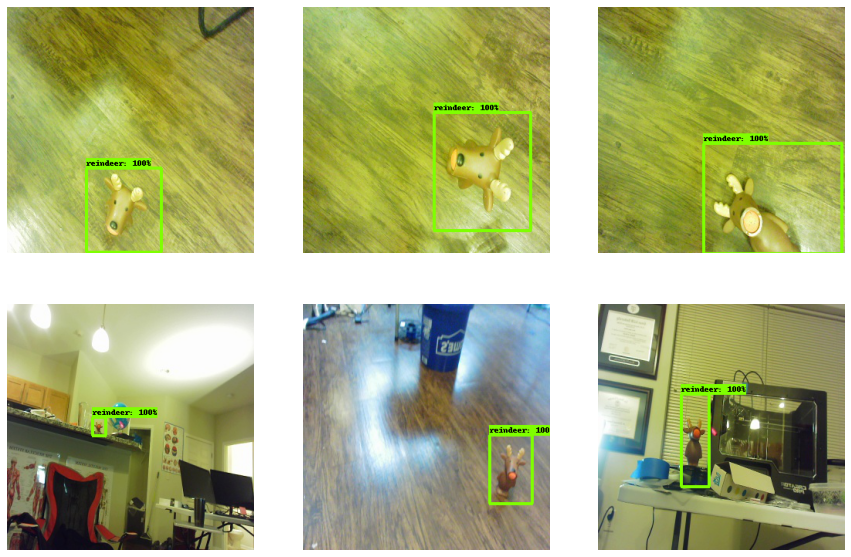

In [ ]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(15, 10))
for idx in range(6):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      test_images_np[idx][0],
      test_gt_boxes[idx],
      np.ones(shape=[test_gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
  plt.axis('off')
plt.show()

# 4. Import New Tflite Model <a class="anchor" id="Code_Objective_4"></a>

In [108]:
model_path='/content/drive/MyDrive/Colab Notebooks/MrRobot/augmented_ssd_MobileNet_v2_FPNLite_320x320_5_8_2021_reindeer/augmented_ssd_MobileNet_v2FPNLite_320_5_8_2021_reindeer_model_toy.tflite'
#model_path='/content/drive/MyDrive/Colab Notebooks/MrRobot/no_augmented_ssd_MobileNet_v2_FPNLite_320x320 5_8_2021_reindeer/no_augmented_ssd_MobileNet_v2FPNLite_320_5_8_2021_reindeer_model_toy.tflite'

In [109]:
file_id=model_path.split('/')[-1].split('model_toy.tflite')[0]
file_id

'augmented_ssd_MobileNet_v2FPNLite_320_5_8_2021_reindeer_'

# 5. Evaluate Test Images <a class="anchor" id="Code_Objective_5"></a>

In [110]:
def detect(interpreter, input_tensor,data):
  """Run detection on an input image.

  Args:
    interpreter: tf.lite.Interpreter
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # We use the original model for pre-processing, since the TFLite model doesn't
  # include pre-processing.
  # sjs edit 2/27/2021, trying to see input_data instead of preprocessed_image
  #preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  

  input_data= tf.convert_to_tensor(data[i], dtype=tf.float32)
  #interpreter.set_tensor(input_details[0]['index'], preprocessed_image.numpy())
  interpreter.set_tensor(input_details[0]['index'], input_data/255)

  interpreter.invoke()

  boxes = interpreter.get_tensor(output_details[0]['index'])
  classes = interpreter.get_tensor(output_details[1]['index'])
  scores = interpreter.get_tensor(output_details[2]['index'])
  return boxes, classes, scores

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  boxes, classes, scores = detect(interpreter, input_tensor,test_images_np)
  if np.max(scores)>0.4:
    plot_detections(
        test_images_np[i][0],
        boxes[0],
        classes[0].astype(np.uint32) + label_id_offset,
        scores[0],
        category_index, figsize=(15, 20), image_name=f"{file_id}_Gif_frame_" + ('%02d' % i) + ".jpg", thresh=max(np.max(scores)-0.01,0.4))

In [111]:
def draw_bounding_box_on_image(image, xmin, ymin, xmax, ymax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    
    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """
  
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.
    
    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
                           
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).
    
    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.
    
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    draw_bounding_boxes_on_image(image, boxes, color, thickness)
  
    return image
# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])
    
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)

In [112]:
predicted_bboxes=[]
normalized_bboxes=[]
scores_bboxes=[]
for i in range(0,len(test_images_np)):
  label_id_offset = 1
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  boxes, classes, scores = detect(interpreter, input_tensor,test_images_np)
  boxes_c=boxes[0].copy()
  predicted_bboxes.append(boxes[0][0])
  boxes_c=test_gt_boxes[i].copy()
  normalized_bboxes.append(test_gt_boxes[i][0])

  scores_bboxes.append(scores[0][0])

predicted_bboxes=np.asarray(predicted_bboxes)
normalized_bboxes=np.asarray(normalized_bboxes)
scores_bboxes=np.asarray(scores_bboxes)

In [113]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou


#Calculates IOU and reports true positives and false positives based on IOU threshold
predicted_bboxes=np.asarray(predicted_bboxes)
normalized_bboxes=np.asarray(normalized_bboxes)
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
TP=((iou >= iou_threshold)) #True Positives
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))
FP=((iou < iou_threshold)) #False Positivies
#Precision=TP/(TP+FP)
#Recall=TP/(GT)

Number of predictions where iou > threshold(0.5): 82
Number of predictions where iou < threshold(0.5): 20


In [114]:
df_AP=pd.DataFrame(np.zeros(shape=(len(normalized_bboxes),5)),columns=['score','TP/FP','Precision','Recall','Precision_inter']).astype(str)
df_AP['Precision_inter']=df_AP['Precision_inter'].astype(float)
df_AP['Precision']=df_AP['Precision'].astype(float)
df_AP['Recall']=df_AP['Recall'].astype(float)
df_AP['score']=df_AP['score'].astype(float)
for i,(score_i,TP_i,FP_i) in enumerate(zip(list(scores_bboxes),TP,FP)):
  if TP_i==True:
    df_AP.at[i,'TP/FP']='TP'
  else:
    df_AP.at[i,'TP/FP']='FP'
  df_AP.at[i,'score']=score_i
df_AP=df_AP.sort_values(by='score',ascending=False).reset_index().drop('index',axis=1)
TP_cum=0
GT=len(df_AP[df_AP['TP/FP']=='TP'])
print(f'GT = {GT}')
for i in range(len(df_AP)):
  if df_AP['TP/FP'][i]=='TP':
    TP_cum+=1
  df_AP.at[i,'Precision']=TP_cum/(i+1)
  df_AP.at[i,'Recall']=TP_cum/GT
df_AP=df_AP.sort_values(by='Recall',ascending=True).reset_index().drop('index',axis=1)
for i in range(len(df_AP)):
  if df_AP['TP/FP'][i]=='TP':
    df_AP.at[i,'Precision_inter']=df_AP['Precision'][i]
  else:
    if i>=1:
      #df_AP.at[i,'Precision_inter']=np.max((df_AP['Precision'][i],df_AP['Precision_inter'][i-1]))
      df_AP.at[i,'Precision_inter']=df_AP['Precision_inter'][i-1]
    elif i==0:
      df_AP.at[i,'Precision_inter']=df_AP['Precision'][i]
df_AP=df_AP.sort_values(by='Recall',ascending=False).reset_index().drop('index',axis=1)
for i in range(len(df_AP)-1):
  if df_AP['Precision_inter'][i]>=df_AP['Precision_inter'][i+1]:
    df_AP.at[i+1,'Precision_inter']=df_AP['Precision_inter'][i]
df_AP=df_AP.sort_values(by='Recall',ascending=True).reset_index().drop('index',axis=1)
df_AP.at[0,'Precision_inter']=df_AP['Precision'].max()


GT = 82


In [115]:
df_AP['AUC']=0.0
mean_i=0.
for i in range(1,len(df_AP)):
  mean_i=(df_AP['Recall'][i]-df_AP['Recall'][i-1])*np.mean((df_AP['Precision_inter'][i-1],df_AP['Precision_inter'][i]))+mean_i
  df_AP.at[i,'AUC']=mean_i

In [116]:
AP_50=max(df_AP['AUC'])
AP_50

0.9171153462466584

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


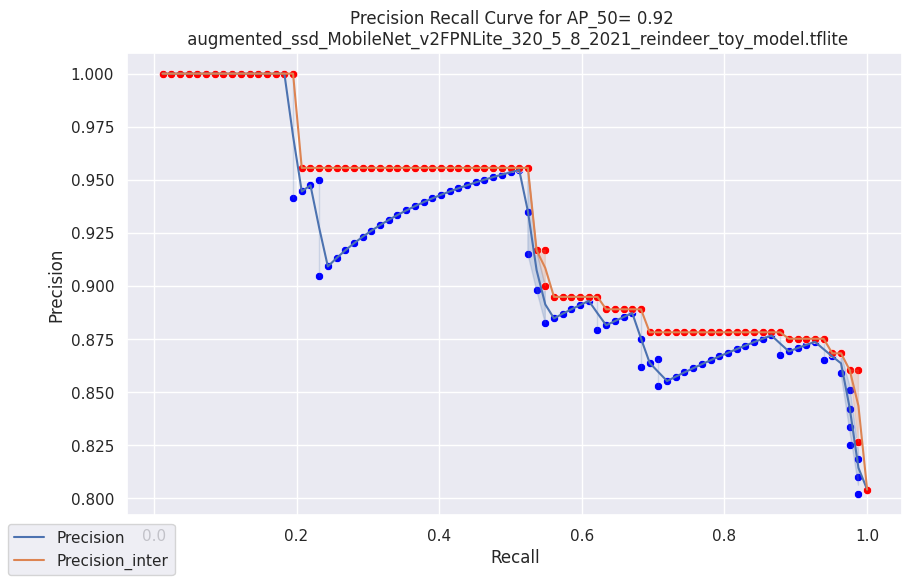

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
fig=plt.figure(figsize=(10,6))
sns.scatterplot(df_AP['Recall'],df_AP['Precision'],color='Blue').set(title=f'Precision Recall Curve for AP_50= {np.round(AP_50,2)} \n {file_id}toy_model.tflite')
sns.lineplot(data=df_AP[['Recall','Precision']].astype(float),x='Recall',y='Precision')
sns.scatterplot(df_AP['Recall'],df_AP['Precision_inter'],color='Red')
sns.lineplot(data=df_AP[['Recall','Precision_inter']].astype(float),x='Recall',y='Precision_inter',legend='auto')
fig.legend(labels=['Precision','Precision_inter'],loc='lower left')
plt.show()

In [118]:
import importlib
importlib.reload(sns)
sns.reset_defaults()
importlib.reload(plt)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

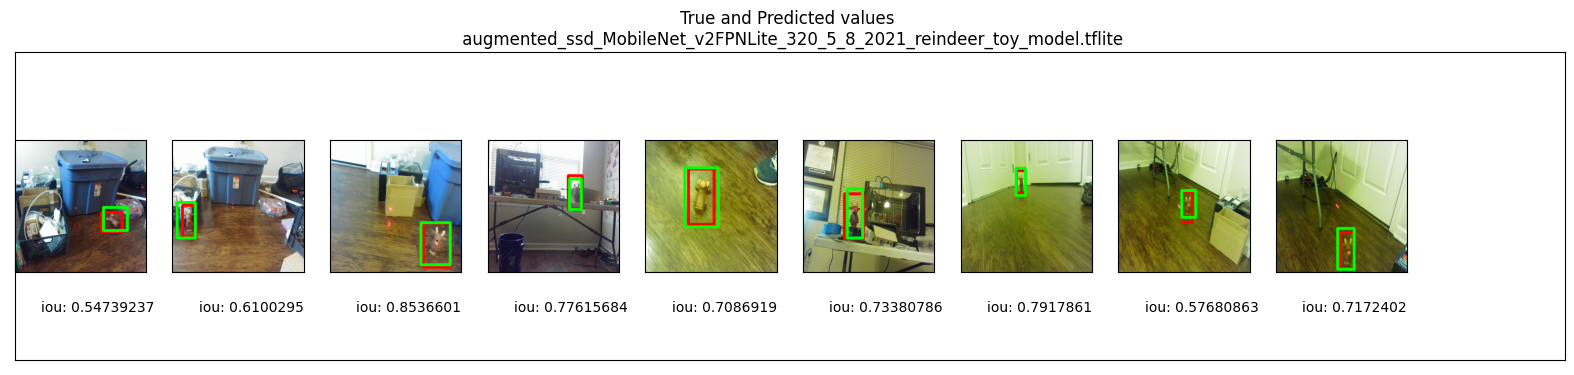

In [119]:
import cv2
np.random.seed(seed=1)
n = 9
iou[np.where(iou<1e-4)]=0.0
indexes = np.random.choice(len(predicted_bboxes), size=n)
iou_to_draw = iou[indexes]
norm_to_draw = np.squeeze(np.asarray(test_images_np)[indexes.astype(int)])
display_digits_with_boxes(norm_to_draw, predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], f"True and Predicted values \n {file_id}toy_model.tflite", bboxes_normalized=True)

# 6. Create A GIF <a class="anchor" id="Code_Objective_6"></a>

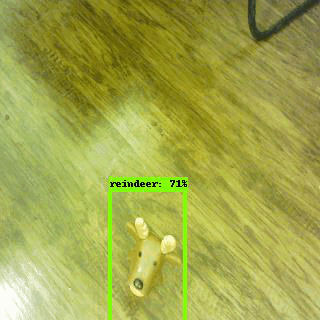

In [120]:
imageio.plugins.freeimage.download()

anim_file = f'{file_id}_toy_test.gif'

filenames = glob.glob(f'{file_id}_Gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)
  #print(filename)
  #fi=plt.imread(filename)
  #plt.imshow(fi)
  #plt.show()

imageio.mimsave(anim_file, images, 'GIF-FI', fps=1)

display(IPyImage(open(anim_file, 'rb').read()))

# 7. References <a class="anchor" id="Code_Objective_7"></a>

1. TensorFlow 2 Detection Model Zoo, [https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md]<a class="anchor" id="Ref_1"></a>  

2. SSD MobilNet V2 FPNLite 320x320, [http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz] <a class="anchor" id="Ref_2"></a>   

3. Liu, Wei et al. "SSD: Single Shot MultiBox Detector" [https://arxiv.org/abs/1512.02325] <a class="anchor" id="Ref_3"></a>   

4. TensorFlow.  Martín Abadi, Ashish Agarwal, Paul Barham, Eugene Brevdo, Zhifeng Chen, Craig Citro, Greg S. Corrado, Andy Davis,Jeffrey Dean, Matthieu Devin, Sanjay Ghemawat, Ian Goodfellow, Andrew Harp, Geoffrey Irving, Michael Isard, Rafal Jozefowicz, Yangqing Jia,Lukasz Kaiser, Manjunath Kudlur, Josh Levenberg, Dan Mané, Mike Schuster,Rajat Monga, Sherry Moore, Derek Murray, Chris Olah, Jonathon Shlens,Benoit Steiner, Ilya Sutskever, Kunal Talwar, Paul Tucker,Vincent Vanhoucke, Vijay Vasudevan, Fernanda Viégas,Oriol Vinyals, Pete Warden, Martin Wattenberg, Martin Wicke,Yuan Yu, and Xiaoqiang Zheng.  TensorFlow: Large-scale machine learning on heterogeneous systems, 2015. Software available from tensorflow.org. <a class="anchor" id="Ref_4"></a>   

5. LabelImg. [https://github.com/tzutalin/labelImg] <a class="anchor" id="Ref_5"></a>   

6. Bradski, G., & Kaehler, A. (2008). Learning OpenCV: Computer vision with the OpenCV library. " O&#x27;Reilly Media, Inc." <a class="anchor" id="Ref_6"></a>   

7.  SciPy. Pauli Virtanen, Ralf Gommers, Travis E. Oliphant, Matt Haberland, Tyler Reddy, David Cournapeau, Evgeni Burovski, Pearu Peterson, Warren Weckesser, Jonathan Bright, Stéfan J. van der Walt, Matthew Brett, Joshua Wilson, K. Jarrod Millman, Nikolay Mayorov, Andrew R. J. Nelson, Eric Jones, Robert Kern, Eric Larson, CJ Carey, İlhan Polat, Yu Feng, Eric W. Moore, Jake VanderPlas, Denis Laxalde, Josef Perktold, Robert Cimrman, Ian Henriksen, E.A. Quintero, Charles R Harris, Anne M. Archibald, Antônio H. Ribeiro, Fabian Pedregosa, Paul van Mulbregt, and SciPy 1.0 Contributors. (2019) SciPy 1.0–Fundamental Algorithms for Scientific Computing in Python. preprint arXiv:1907.10121 <a class="anchor" id="Ref_7"></a>   

8.  Python. a) Travis E. Oliphant. Python for Scientific Computing, Computing in Science & Engineering, 9, 10–20 (2007) b) K. Jarrod Millman and Michael Aivazis. Python for Scientists and Engineers, Computing in Science & Engineering, 13, 9–12 (2011) <a class="anchor" id="Ref_8"></a>   

9.  NumPy. a) Travis E. Oliphant. A guide to NumPy, USA: Trelgol Publishing, (2006). b) Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22–30 (2011) <a class="anchor" id="Ref_9"></a>   

10.  IPython. a) Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21–29 (2007) <a class="anchor" id="Ref_10"></a>   

11.  Matplotlib. J. D. Hunter, “Matplotlib: A 2D Graphics Environment”, Computing in Science & Engineering, vol. 9, no. 3, pp. 90–95, 2007. <a class="anchor" id="Ref_11"></a>   

12.  Pandas. Wes McKinney. Data Structures for Statistical Computing in Python, Proceedings of the 9th Python in Science Conference, 51–56 (2010) <a class="anchor" id="Ref_12"></a>   

13. Scikit-Learn. Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825–2830 (2011) <a class="anchor" id="Ref_13"></a>   

14.  Scikit-Image. Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu and the scikit-image contributors. scikit-image: Image processing in Python, PeerJ 2:e453 (2014) <a class="anchor" id="Ref_14"></a>   